<a href="https://colab.research.google.com/github/kairamilanifitria/PurpleBox-Intern/blob/main/02032025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Qwen with bs64 input
convert the image pages into bs64 image format, then forward it into qwen to reduce resource limitation (still in progress)

In [1]:
!pip install transformers accelerate numpy Requests torch torchvision qwen-vl-utils av ipython reportlab fpdf python-docx pillow huggingface_hub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.1 MB/s eta 0:00:00
   ━━━

In [2]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, TextIteratorStreamer
from qwen_vl_utils import process_vision_info
from PIL import Image
import base64
import uuid
import io
from threading import Thread

In [3]:
# Load the model and processor
model_name = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name, trust_remote_code=True, torch_dtype=torch.float16
).to("cuda").eval()
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

image_extensions = Image.registered_extensions()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [4]:
def decode_base64_to_image(base64_string):
    """Decodes a base64 string and saves it as a temporary image file."""
    image_data = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(image_data))

    filename = f"temp_{uuid.uuid4()}.png"  # Always save as PNG
    image.save(filename)

    return filename  # Return the path to the saved image

def qwen_inference(media_input, text_input=None):
    """Handles inference for Qwen-VL, supporting both file paths and base64 strings."""
    if isinstance(media_input, str):
        if media_input.startswith("data:image"):  # Detect base64 input
            base64_str = media_input.split(",")[1]  # Remove the base64 header
            media_path = decode_base64_to_image(base64_str)
        elif media_input.endswith(tuple(image_extensions.keys())):  # If it's a file path
            media_path = media_input
        else:
            raise ValueError("Unsupported media type. Please provide a valid image path or base64 string.")

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": media_path},
                {"type": "text", "text": text_input},
            ],
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)

    inputs = processor(text=[text], images=image_inputs, padding=True, return_tensors="pt").to("cuda")

    # Run the model in a separate thread
    streamer = TextIteratorStreamer(
        processor.tokenizer, skip_prompt=True, skip_special_tokens=True
    )
    generation_kwargs = dict(inputs, streamer=streamer, max_new_tokens=1024)

    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()

    buffer = ""
    for new_text in streamer:
        buffer += new_text
        buffer = buffer.replace("<|im_end|>", "")  # Remove unwanted tokens
        yield buffer

### example 1

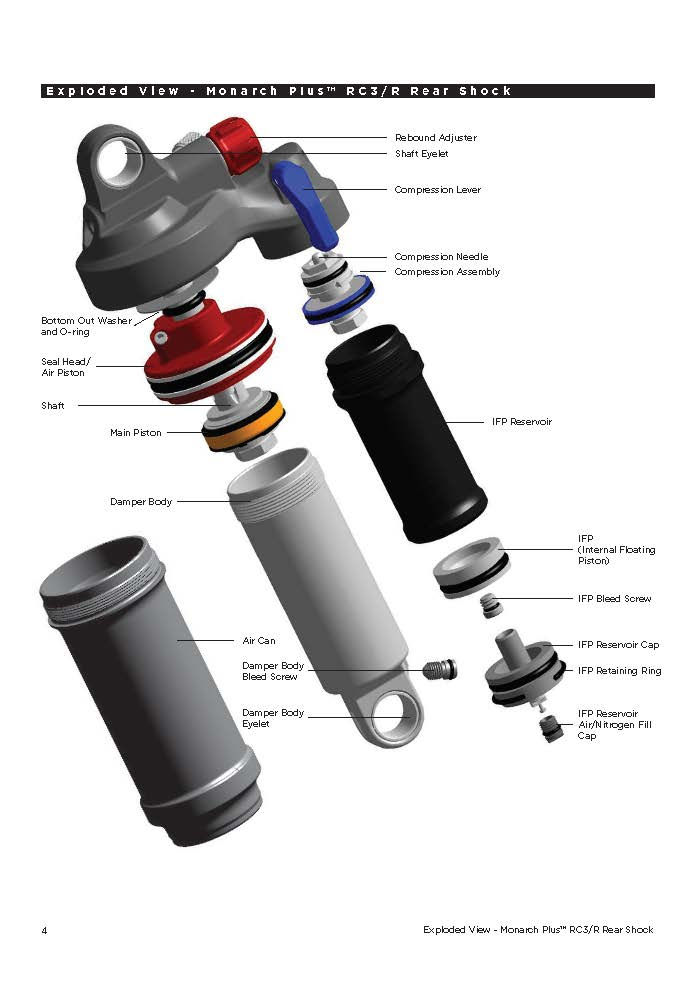

In [5]:
# File path example:
media_input = "/content/pg5.jpg"
text_input = "Describe this image."

output = list(qwen_inference(media_input, text_input))
print(output[-1])

The image is an exploded view of a Monarch Plus RC3/R Rear Shock, which is a type of shock absorber used in off-road vehicles. The exploded view is labeled "Exploded View - Monarch Plus RC3/R Rear Shock." The components of the shock are clearly labeled with their respective parts and functions.

1. **Shaft**: The main component of the shock, which is the cylindrical part that connects the piston to the piston rod.
2. **Main Piston**: The piston that moves inside the shock body.
3. **IFP Reservoir**: A cylindrical reservoir that contains the fluid used to absorb shock waves.
4. **IFP Reservoir Cap**: The cap that covers the top of the IFP reservoir.
5. **IFP Bleed Screw**: A screw used to bleed air from the IFP reservoir.
6. **IFP Retaining Ring**: A ring that holds the IFP reservoir in place.
7. **IFP Reservoir Cap**: The cap that covers the top of the IFP reservoir.
8. **IFP (Internal Floating Piston)**: The piston that moves inside the IFP reservoir.
9. **IFP Bleed Screw**: The screw

In [6]:
# File path example:
media_input = "/content/pg5.jpg"
text_input = "Take the information of the image, give the best description, avoid hallucation, just give the context and essential information."

output = list(qwen_inference(media_input, text_input))
print(output[-1])

The image is an exploded view diagram of a Monarch Plus RC3/R Rear Shock. The diagram is labeled with various parts and their functions, providing a detailed breakdown of the components. Here is a detailed description:

1. **Shaft**: The central component of the shock, responsible for transmitting force from the suspension to the ground.
2. **Main Piston**: The core component that moves up and down, controlling the shock's compression and rebound.
3. **IFP Reservoir**: A reservoir for air or nitrogen, used to fill the shock with air or nitrogen to adjust the shock's compression.
4. **IFP (Internal Floating Piston)**: A floating piston inside the reservoir that allows for the shock's compression and rebound.
5. **IFP Bleed Screw**: Used to bleed air from the reservoir, ensuring proper air pressure.
6. **IFP Reservoir Cap**: A cap that seals the reservoir to prevent air from escaping.
7. **IFP Retaining Ring**: A ring that holds the reservoir in place.
8. **IFP Reservoir Air/Nitrogen Fil

better prompt -> better result

### example 2

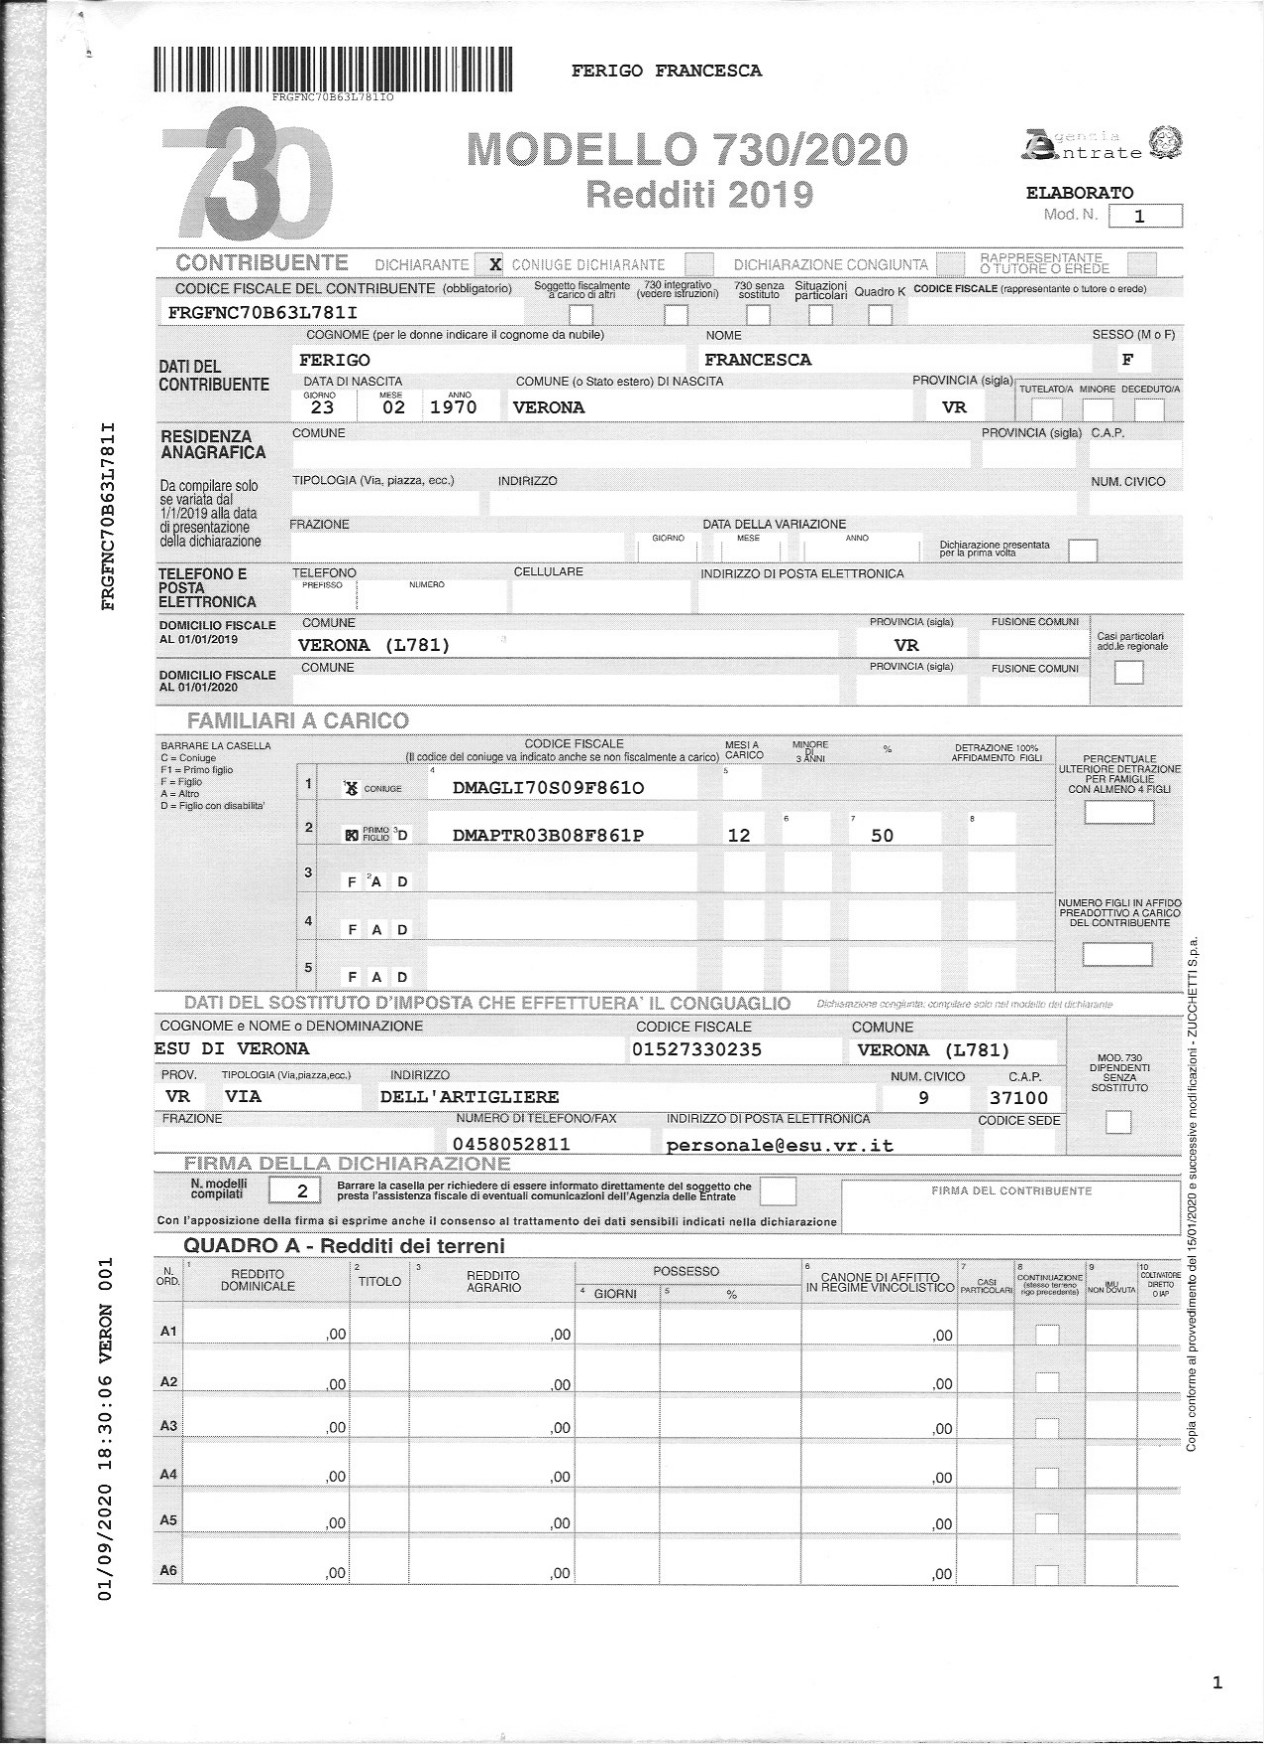

In [5]:
torch.cuda.empty_cache()

In [6]:
# File path example:
media_input = "/content/modello-730-2020-FERIGO-FRANCESCA.jpg"
text_input = "Take the information of the image, give the best description, avoid hallucation, just give the context and essential information."

output = list(qwen_inference(media_input, text_input))
print(output[-1])

Exception in thread Thread-12 (generate):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py", line 2252, in generate
    result = self._sample(
             ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py", line 3251, in _sample
    outputs = self(**model_inputs, return_dict=True)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

## MARKER VS DOCLING (convert into .md)

marker library explanation : https://github.com/VikParuchuri/marker

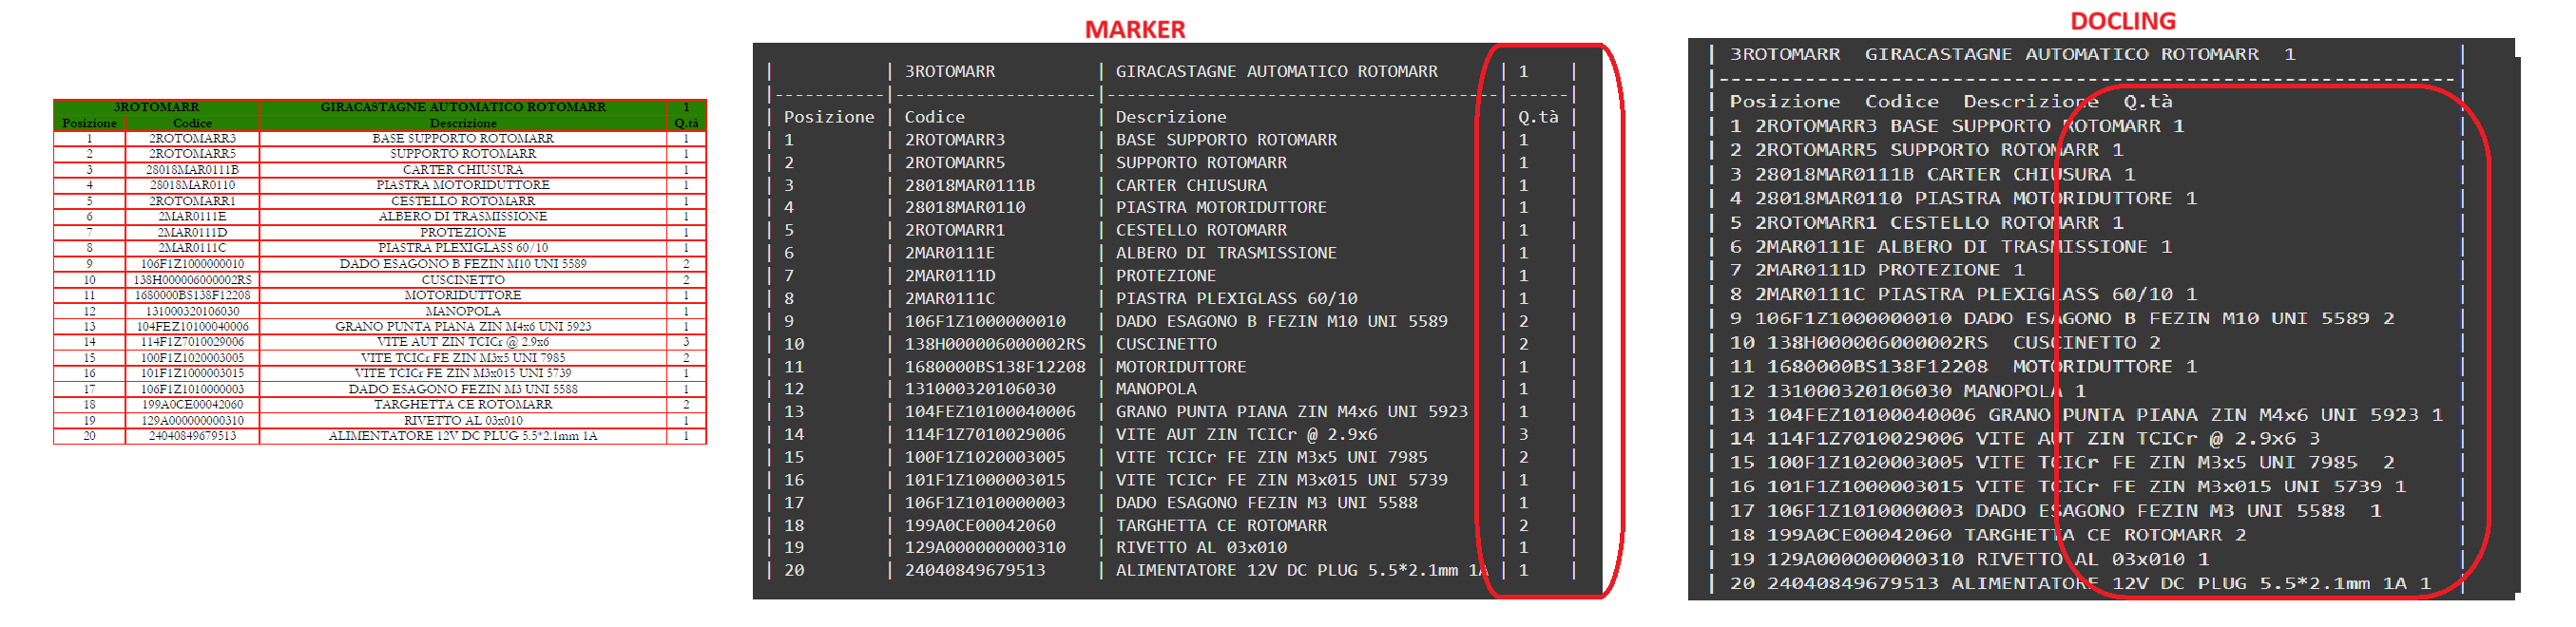

### marker

In [1]:
!pip install marker-pdf

In [9]:
!marker_single /content/Manuale_ROTOMARR.pdf

2025-02-03 11:56:39.889116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738583799.924601   16243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738583799.935555   16243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 11:56:39.969275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
config.json: 100% 6.01k/6.01k [00:00<00:00, 29.9MB/s]
model.safetensors: 100% 253M/253M [00:05<00:00, 42.7MB/s]
Loade

In [11]:
# This appears to be a file path, not Python code.
# If you intend to use this in Python code, you'll likely need to use it within a string, e.g.,
# file_path = "/usr/local/lib/python3.11/dist-packages/conversion_results/Manuale_ROTOMARR"
#
# Or if you intend to execute a shell command:
!ls /usr/local/lib/python3.11/dist-packages/conversion_results/Manuale_ROTOMARR
#
# Please provide the context in which you're using this path.

Manuale_ROTOMARR.md	    _page_1_Picture_1.jpeg   _page_2_Picture_14.jpeg
Manuale_ROTOMARR_meta.json  _page_1_Picture_21.jpeg  _page_3_Figure_2.jpeg
_page_0_Picture_1.jpeg	    _page_1_Picture_27.jpeg  _page_3_Picture_1.jpeg
_page_0_Picture_2.jpeg	    _page_1_Picture_32.jpeg
_page_1_Figure_17.jpeg	    _page_2_Picture_0.jpeg


In [13]:
# move the /usr/local/lib/python3.11/dist-packages/conversion_results/Manuale_ROTOMARR into /content/modello

import shutil
import os

source_path = "/usr/local/lib/python3.11/dist-packages/conversion_results/Manuale_ROTOMARR"
destination_path = "/content/modello"

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

try:
  # Use shutil.move to move the directory
  shutil.move(source_path, destination_path)
  print(f"Successfully moved {source_path} to {destination_path}")
except FileNotFoundError:
  print(f"Error: Source directory '{source_path}' not found.")
except OSError as e:
  print(f"Error moving directory: {e}")


Successfully moved /usr/local/lib/python3.11/dist-packages/conversion_results/Manuale_ROTOMARR to /content/modello


In [15]:
# show the markdown (.md) file

!cat /content/modello/Manuale_ROTOMARR/Manuale_ROTOMARR.md


![](_page_0_Picture_1.jpeg)

![](_page_0_Picture_2.jpeg)

## **GIRACASTAGNE AUTOMATICO ROTOMARR**

### **1. INFORMAZIONI SULLA SICUREZZA**

Il presente manuale contiene indicazioni ed informazioni fondamentali per il corretto utilizzo del GIRACASTAGNE AUTOMATICO (CUOCI CALDARROSTE) **ROTOMARR**.

- Leggere il manuale nella sua completezza per comprendere l'utilizzo della macchina;
- Tenere questo manuale per future consultazioni in un luogo sicuro;
- Osservare le istruzioni indicate in questo manuale per garantire la sicurezza dell'utilizzatore;
- La non osservanza delle indicazioni elencate in questo manuale comporterà l'annullamento della garanzia;
- MECTRONICA S.r.l. non è responsabile per danni o lesioni causate dalla non osservanza delle informazioni elencate nel presente manuale.

### **2. SPECIFICHE**

Il GIRACASTAGNE AUTOMATICO **ROTOMARR** entra in funzionamento grazie ad un alimentatore elettrico con le seguenti caratteristiche:

| Voltaggio di alimentazione: | 12 Volts DC   

In [16]:
!marker_single /content/Manuale_ROTOMARR.pdf --output_dir /content/modello2

2025-02-03 12:10:21.250244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738584621.286234   19738 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738584621.298099   19738 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 12:10:21.337657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Loaded layout model datalab-to/surya_layout on device cuda with dtype torch.float16
Loaded texify model datalab-to/te

In [17]:
!cat /content/modello2/Manuale_ROTOMARR/Manuale_ROTOMARR.md

![](_page_0_Picture_1.jpeg)

![](_page_0_Picture_2.jpeg)

## **GIRACASTAGNE AUTOMATICO ROTOMARR**

### **1. INFORMAZIONI SULLA SICUREZZA**

Il presente manuale contiene indicazioni ed informazioni fondamentali per il corretto utilizzo del GIRACASTAGNE AUTOMATICO (CUOCI CALDARROSTE) **ROTOMARR**.

- Leggere il manuale nella sua completezza per comprendere l'utilizzo della macchina;
- Tenere questo manuale per future consultazioni in un luogo sicuro;
- Osservare le istruzioni indicate in questo manuale per garantire la sicurezza dell'utilizzatore;
- La non osservanza delle indicazioni elencate in questo manuale comporterà l'annullamento della garanzia;
- MECTRONICA S.r.l. non è responsabile per danni o lesioni causate dalla non osservanza delle informazioni elencate nel presente manuale.

### **2. SPECIFICHE**

Il GIRACASTAGNE AUTOMATICO **ROTOMARR** entra in funzionamento grazie ad un alimentatore elettrico con le seguenti caratteristiche:

| Voltaggio di alimentazione: | 12 Volts DC   

### docling

In [18]:
!pip install llama-index-node-parser-docling>=0.3.0 llama-index-readers-docling>=0.3.0

In [19]:
import json
import logging
from pathlib import Path

import yaml

from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.document_converter import (
    DocumentConverter,
    PdfFormatOption,
    WordFormatOption,
)
from docling.pipeline.simple_pipeline import SimplePipeline
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline

_log = logging.getLogger(__name__)

In [21]:
# English Files
!mkdir -p data

!mv /content/Manuale_ROTOMARR.pdf data/Manuale_ROTOMARR.pdf

In [25]:
def main():
    input_paths = [
        Path("/content/data/Manuale_ROTOMARR.pdf"),
    ]

    doc_converter = (
        DocumentConverter(  # all of the below is optional, has internal defaults.
            allowed_formats=[
                InputFormat.PDF,
                InputFormat.IMAGE,
                InputFormat.DOCX,
                InputFormat.HTML,
                InputFormat.PPTX,
                InputFormat.ASCIIDOC,
                InputFormat.MD,
            ],  # whitelist formats, non-matching files are ignored.
            format_options={
                InputFormat.PDF: PdfFormatOption(
                    pipeline_cls=StandardPdfPipeline, backend=PyPdfiumDocumentBackend
                ),
                InputFormat.DOCX: WordFormatOption(
                    pipeline_cls=SimplePipeline  # , backend=MsWordDocumentBackend
                ),
            },
        )
    )

    conv_results = doc_converter.convert_all(input_paths)

    for res in conv_results:
        out_path = Path("scratch")
        out_path.mkdir(parents=True, exist_ok=True)
        print(
            f"Document {res.input.file.name} converted."
            f"\nSaved markdown output to: {str(out_path)}"
        )
        _log.debug(res.document._export_to_indented_text(max_text_len=16))
        # Export Docling document format to markdowndoc:
        with (out_path / f"{res.input.file.stem}.md").open("w", encoding="utf-8") as fp:
            fp.write(res.document.export_to_markdown())

        with (out_path / f"{res.input.file.stem}.json").open("w", encoding="utf-8") as fp: # Specify 'utf-8' encoding to handle Unicode characters
            fp.write(json.dumps(res.document.export_to_dict()))

        with (out_path / f"{res.input.file.stem}.yaml").open("w", encoding="utf-8") as fp: # Specify 'utf-8' encoding to handle Unicode characters
            fp.write(yaml.safe_dump(res.document.export_to_dict()))

In [29]:
if __name__ == "__main__":
    main()

Document Manuale_ROTOMARR.pdf converted.
Saved markdown output to: scratch


In [36]:
with open('/content/scratch/Manuale_ROTOMARR.md', 'r', encoding='utf-8') as f:
    print(f.read())

<!-- image -->

GIRACASTAGNE AUTOMATICO ROTOMARR

<!-- image -->

## 1. INFORMAZIONI SULLA SICUREZZA

Il presente manuale contiene indicazioni ed informazioni fondamentali per il corretto utilizzo del GIRACASTAGNE AUTOMATICO (CUOCI CALDARROSTE) ROTOMARR .

- -Leggere il manuale nella sua completezza per comprendere l'utilizzo della macchina;
- -Tenere questo manuale per future consultazioni in un luogo sicuro;
- -Osservare le istruzioni indicate in questo manuale per garantire la sicurezza dell'utilizzatore;
- -La non osservanza delle indicazioni elencate in questo manuale comporterà l'annullamento della garanzia;
- -MECTRONICA S.r.l. non è responsabile per danni o lesioni causate dalla non osservanza delle informazioni elencate nel presente manuale.

## 2. SPECIFICHE

Il GIRACASTAGNE AUTOMATICO ROTOMARR entra in funzionamento grazie ad un alimentatore elettrico con le seguenti caratteristiche:

Voltaggio di alimentazione:

12 Volts DC

Amperaggio:

1 A

Dimensione connessione:

5,5*2,

## unstructured io (ERROR)


In [4]:
%%capture
%pip install "unstructured[all-docs]"

In [5]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [6]:
from IPython.display import JSON

import json
from unstructured.partition.html import partition_html
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import dict_to_elements, elements_to_json

In [6]:
%pip show unstructured

In [7]:
import unstructured.partition

help(unstructured.partition)

Help on package unstructured.partition in unstructured:

NAME
    unstructured.partition

PACKAGE CONTENTS
    api
    auto
    common (package)
    csv
    doc
    docx
    email
    epub
    html (package)
    image
    json
    md
    model_init
    msg
    ndjson
    odt
    org
    pdf
    pdf_image (package)
    ppt
    pptx
    rst
    rtf
    strategies
    text
    text_type
    tsv
    utils (package)
    xlsx
    xml

FILE
    /usr/local/lib/python3.11/dist-packages/unstructured/partition/__init__.py




In [12]:
!apt-get install poppler-utils # Install poppler-utils using apt-get

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (134 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124997 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [13]:
from unstructured.partition.pdf import partition_pdf

# Specify the path to your PDF file
filename = "/content/modello-730-2020-FERIGO-FRANCESCA.pdf"

# Call the partition_pdf function
# Returns a List[Element] present in the pages of the parsed pdf document
elements = partition_pdf(filename)

# Now, elements is a list of all elements present in the pages of the parsed pdf document

In [14]:
elements

In [15]:
len(elements)

395

In [16]:
element_dict = [el.to_dict() for el in elements]
output = json.dumps(element_dict, indent=2)
print(output)

[
  {
    "type": "Title",
    "element_id": "535e6b3d4b86da5cf0115a0793fa707c",
    "text": "FRGFNC70B63L7811",
    "metadata": {
      "coordinates": {
        "points": [
          [
            208.0,
            880.0
          ],
          [
            208.0,
            1271.0
          ],
          [
            238.0,
            1271.0
          ],
          [
            238.0,
            880.0
          ]
        ],
        "system": "PixelSpace",
        "layout_width": 2634,
        "layout_height": 3634
      },
      "filetype": "application/pdf",
      "languages": [
        "eng"
      ],
      "last_modified": "2025-02-03T11:07:01",
      "page_number": 1,
      "file_directory": "/content",
      "filename": "modello-730-2020-FERIGO-FRANCESCA.pdf"
    }
  },
  {
    "type": "UncategorizedText",
    "element_id": "24568a17f0c51c1980435d72ad257891",
    "text": "01/09/2020 18:30:06 VERON 001",
    "metadata": {
      "coordinates": {
        "points": [
          [


In [17]:
unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

{'Title', 'UncategorizedText', 'ListItem', 'NarrativeText'}


In [19]:
from unstructured.partition.pdf import partition_pdf

# Specify the path to your PDF file
filename = "/content/modello-730-2020-FERIGO-FRANCESCA.pdf"

# Call the partition_pdf function
# Returns a List[Element] present in the pages of the parsed pdf document
elements = partition_pdf(filename)

# Now, elements is a list of all elements present in the pages of the parsed pdf document

In [20]:
elements

In [21]:
len(elements)

395

In [22]:
element_dict = [el.to_dict() for el in elements]
output = json.dumps(element_dict, indent=2)
print(output)

[
  {
    "type": "Title",
    "element_id": "535e6b3d4b86da5cf0115a0793fa707c",
    "text": "FRGFNC70B63L7811",
    "metadata": {
      "coordinates": {
        "points": [
          [
            208.0,
            880.0
          ],
          [
            208.0,
            1271.0
          ],
          [
            238.0,
            1271.0
          ],
          [
            238.0,
            880.0
          ]
        ],
        "system": "PixelSpace",
        "layout_width": 2634,
        "layout_height": 3634
      },
      "filetype": "application/pdf",
      "languages": [
        "eng"
      ],
      "last_modified": "2025-02-03T11:07:01",
      "page_number": 1,
      "file_directory": "/content",
      "filename": "modello-730-2020-FERIGO-FRANCESCA.pdf"
    }
  },
  {
    "type": "UncategorizedText",
    "element_id": "24568a17f0c51c1980435d72ad257891",
    "text": "01/09/2020 18:30:06 VERON 001",
    "metadata": {
      "coordinates": {
        "points": [
          [


In [23]:
from unstructured.partition.pdf import partition_pdf

elements = partition_pdf(filename=filename,
                         infer_table_structure=True,
                         strategy='hi_res',
           )

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [24]:
len(elements)

280

In [25]:
element_dict = [el.to_dict() for el in elements]
output = json.dumps(element_dict, indent=2)
print(output)

unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

[
  {
    "type": "Header",
    "element_id": "535e6b3d4b86da5cf0115a0793fa707c",
    "text": "FRGFNC70B63L7811",
    "metadata": {
      "detection_class_prob": 0.5370449423789978,
      "coordinates": {
        "points": [
          [
            200.00363159179688,
            892.22216796875
          ],
          [
            200.00363159179688,
            1282.1673583984375
          ],
          [
            244.5747528076172,
            1282.1673583984375
          ],
          [
            244.5747528076172,
            892.22216796875
          ]
        ],
        "system": "PixelSpace",
        "layout_width": 2634,
        "layout_height": 3634
      },
      "last_modified": "2025-02-03T11:07:01",
      "filetype": "application/pdf",
      "languages": [
        "eng"
      ],
      "page_number": 1,
      "file_directory": "/content",
      "filename": "modello-730-2020-FERIGO-FRANCESCA.pdf"
    }
  },
  {
    "type": "UncategorizedText",
    "element_id": "24568a17

In [26]:
tables = [el for el in elements if el.category == "Table"]

print(tables[0].text)
print(tables[0].metadata.text_as_html)

Redditi 2019 aren ee ~CONTRIBUENTE DICHIARANTE | X/ CONIUGE DICHIARANTE [| DICHIARAZIONE CONGIUNTA| | BYTROAEO Btzbe | CODICE FISCALE DEL CONTRIBUENTE (obbligatorio) Soggettoscalmente | 730 iniepraive, 730 senza Smezinl Quadro K CODICE FISCALE (rappresentanie 0 tutore o erade) clinician lent zz oe oe ee TT COGNOME (per le donne indicare il cognome da nubile) NOME : " SESSO (Mo F) DATI DEL FERIGO FRANCESCA CONTRIBUENTE OATA Dl NASCITA COMUNE (0 Siato estero) DI NASCITA OAINO ANNO 02° 1970 VERONA _ RESIDENZA eae PROVINCIA (sgl) CAP. ANAGRAFICA Bacomnibrea solo TIPOLOGIA (Via. piazza, ecc.) INDIRIZZO NUM. CIVICO se variata dal a pesstianore FRAZIONE DATA DELLA VARIAZIONE GIORNO MESE ANNO ste a de pao fo] TELEFONO E “TELEFONO CELLULARE INDIRIZZO DI POSTA ELETTRONICA POSTA PREFISSO | NUMERO ELETTRONICA DOMICILIO FISCALE COMUNE PROVINCIA {sigia) FUSIONE COMUNI i a ELE VERONA (L781) VR | Sab regonale poneciiic COMUNE PROVINCIA (sigia) FUSIONE COMUNI [| AL 01/01/2020 FAMILIARI A CARICO CODICE 

In [27]:
tables

In [28]:
len(tables)

16

In [29]:
tables[0].text

'Redditi 2019 aren ee ~CONTRIBUENTE DICHIARANTE | X/ CONIUGE DICHIARANTE [| DICHIARAZIONE CONGIUNTA| | BYTROAEO Btzbe | CODICE FISCALE DEL CONTRIBUENTE (obbligatorio) Soggettoscalmente | 730 iniepraive, 730 senza Smezinl Quadro K CODICE FISCALE (rappresentanie 0 tutore o erade) clinician lent zz oe oe ee TT COGNOME (per le donne indicare il cognome da nubile) NOME : " SESSO (Mo F) DATI DEL FERIGO FRANCESCA CONTRIBUENTE OATA Dl NASCITA COMUNE (0 Siato estero) DI NASCITA OAINO ANNO 02° 1970 VERONA _ RESIDENZA eae PROVINCIA (sgl) CAP. ANAGRAFICA Bacomnibrea solo TIPOLOGIA (Via. piazza, ecc.) INDIRIZZO NUM. CIVICO se variata dal a pesstianore FRAZIONE DATA DELLA VARIAZIONE GIORNO MESE ANNO ste a de pao fo] TELEFONO E “TELEFONO CELLULARE INDIRIZZO DI POSTA ELETTRONICA POSTA PREFISSO | NUMERO ELETTRONICA DOMICILIO FISCALE COMUNE PROVINCIA {sigia) FUSIONE COMUNI i a ELE VERONA (L781) VR | Sab regonale poneciiic COMUNE PROVINCIA (sigia) FUSIONE COMUNI [| AL 01/01/2020 FAMILIARI A CARICO CODICE

In [30]:
tables[0].metadata

In [31]:
table_html = tables[0].metadata.text_as_html

In [32]:
table_html

'<table><thead><tr><th>—CONTRIBUENTE</th><th colspan="7">IGE DICHIARANTE [|</th><th colspan="3">DICHIARAZIONE CONGIUNTA| |</th><th colspan="2">BATHSRFO TANS.</th></tr><tr><th>CODICE FISCALE</th><th colspan="4">DEL CONTRIBUENTE (obbligatorio)</th><th>Soggetiofiscalmente 730</th><th>integrative,</th><th>730</th><th>senza Situazion|</th><th>Quadro K</th><th colspan="2">CODICE FISCALE (rappresentante o</th><th>tutore © erade)</th></tr></thead><tbody><tr><td colspan="11">FRGFNC7OB63L781000 | be EE 8 8s 1) = da</td><td colspan="2">eee</td></tr><tr><td rowspan="4">DATI DEL CONTRIBUENTE</td><td>COGNOME</td><td>(per</td><td>le donne</td><td>indicare il cognome</td><td>nubile)</td><td></td><td>NOME</td><td></td><td></td><td></td><td></td><td>SESSO (Mo F)</td></tr><tr><td>FERIGO</td><td></td><td></td><td></td><td></td><td></td><td>FRANCESCA</td><td></td><td></td><td></td><td></td><td>F</td></tr><tr><td>GIORNO</td><td>—ATADINASCITA</td><td></td><td>ANNO</td><td colspan="3">(0 Stato estero) DI NASC

In [33]:
from io import StringIO
from lxml import etree

parser = etree.XMLParser(remove_blank_text=True)
file_obj = StringIO(table_html)
tree = etree.parse(file_obj, parser)
print(etree.tostring(tree, pretty_print=True).decode())

<table>
  <thead>
    <tr>
      <th>&#8212;CONTRIBUENTE</th>
      <th colspan="7">IGE DICHIARANTE [|</th>
      <th colspan="3">DICHIARAZIONE CONGIUNTA| |</th>
      <th colspan="2">BATHSRFO TANS.</th>
    </tr>
    <tr>
      <th>CODICE FISCALE</th>
      <th colspan="4">DEL CONTRIBUENTE (obbligatorio)</th>
      <th>Soggetiofiscalmente 730</th>
      <th>integrative,</th>
      <th>730</th>
      <th>senza Situazion|</th>
      <th>Quadro K</th>
      <th colspan="2">CODICE FISCALE (rappresentante o</th>
      <th>tutore &#169; erade)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td colspan="11">FRGFNC7OB63L781000 | be EE 8 8s 1) = da</td>
      <td colspan="2">eee</td>
    </tr>
    <tr>
      <td rowspan="4">DATI DEL CONTRIBUENTE</td>
      <td>COGNOME</td>
      <td>(per</td>
      <td>le donne</td>
      <td>indicare il cognome</td>
      <td>nubile)</td>
      <td/>
      <td>NOME</td>
      <td/>
      <td/>
      <td/>
      <td/>
      <td>SESSO (Mo F)</td>
    </tr>


In [34]:
from IPython.core.display import HTML
HTML(table_html)

In [35]:
import pandas as pd

# Convert HTML table to pandas DataFrame
dfs = pd.read_html(table_html)

In [36]:
dfs

[                                        —CONTRIBUENTE  \
                                        CODICE FISCALE   
 0             FRGFNC7OB63L781000 | be EE 8 8s 1) = da   
 1                               DATI DEL CONTRIBUENTE   
 2                               DATI DEL CONTRIBUENTE   
 3                               DATI DEL CONTRIBUENTE   
 4                               DATI DEL CONTRIBUENTE   
 5                                           RESIDENZA   
 6           Dacompilare solo * ae dal a pesmiaacne te   
 7           Dacompilare solo * ae dal a pesmiaacne te   
 8           Dacompilare solo * ae dal a pesmiaacne te   
 9           Dacompilare solo * ae dal a pesmiaacne te   
 10                   pico TELEFONOE POSTA ELETTRONICA   
 11                   pico TELEFONOE POSTA ELETTRONICA   
 12                   pico TELEFONOE POSTA ELETTRONICA   
 13                   pico TELEFONOE POSTA ELETTRONICA   
 14                                  DOMICILIO FISCALE   
 15           

In [38]:
!pip install pypdf
from pypdf import PdfReader

In [39]:
reader = PdfReader("/content/modello-730-2020-FERIGO-FRANCESCA.pdf")

# Print the number of pages in the PDF
print(f"There are {len(reader.pages)} Pages")

# Get the first page (index 0)
page = reader.pages[0]
# Use extract_text() to get the text of the page
print(page.extract_text())

# Go through every page and get the text
for i in range(len(reader.pages)):
  page = reader.pages[i]
  print(page.extract_text())

There are 14 Pages

















In [42]:
from pypdf import PdfReader

reader = PdfReader("/content/modello-730-2020-FERIGO-FRANCESCA.pdf")

for img in page.images:
    with open(img.name, "wb") as fp:
        fp.write(img.data)